In [4]:
!git clone https://github.com/patil-suraj/onnx_transformers.git
!pip install -U -qqq -e ./onnx_transformers

fatal: destination path 'onnx_transformers' already exists and is not an empty directory.


In [2]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2200.000
BogoMIPS:            4400.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [6]:
from onnx_transformers.onnx_transformers import pipeline

In [7]:
# load onnx pipeline
nlp_onnx = pipeline("feature-extraction",  onnx=True)


Using framework PyTorch: 1.6.0+cu101
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch', 1: 'sequence'}
Ensuring inputs are in correct order
head_mask is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask']


/usr/local/lib/python3.6/dist-packages/transformers/modeling_utils.py:1570: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  input_tensor.shape == tensor_shape for input_tensor in input_tensors


Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch', 1: 'sequence'}


In [8]:
# load torch pipeline
nlp_torch = pipeline("feature-extraction", onnx=False)

In [9]:
from contextlib import contextmanager
from dataclasses import dataclass
from time import time
from tqdm import trange

@contextmanager
def track_infer_time(buffer: [int]):
    start = time()
    yield
    end = time()

    buffer.append(end - start)


@dataclass
class OnnxInferenceResult:
  model_inference_time: [int]  
  optimized_model_path: str

In [10]:
pipelines = [("Pytorch CPU", nlp_torch), ("ONNX CPU", nlp_onnx)]
results = {}
for label, pipeline_ in pipelines:
  # Compute 
  time_buffer = []
  for _ in trange(100, desc=f"Tracking inference time for {label}"):
    with track_infer_time(time_buffer):
      pipeline_("My name is BERT")

  # Store the result
  results[label] = OnnxInferenceResult(
      time_buffer, 
      None
  )

Tracking inference time for ONNX CPU: 100%|██████████| 100/100 [00:04<00:00, 21.60it/s]


In [11]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import os


def plot_benchmark(results):
    # Compute average inference time + std
    time_results = {k: np.mean(v.model_inference_time) * 1e3 for k, v in results.items()}
    time_results_std = np.std([v.model_inference_time for v in results.values()]) * 1000

    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.set_ylabel("Avg Inference time (ms)")
    ax.set_title("Average inference time (ms) for each provider")
    ax.bar(time_results.keys(), time_results.values(), yerr=time_results_std)
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


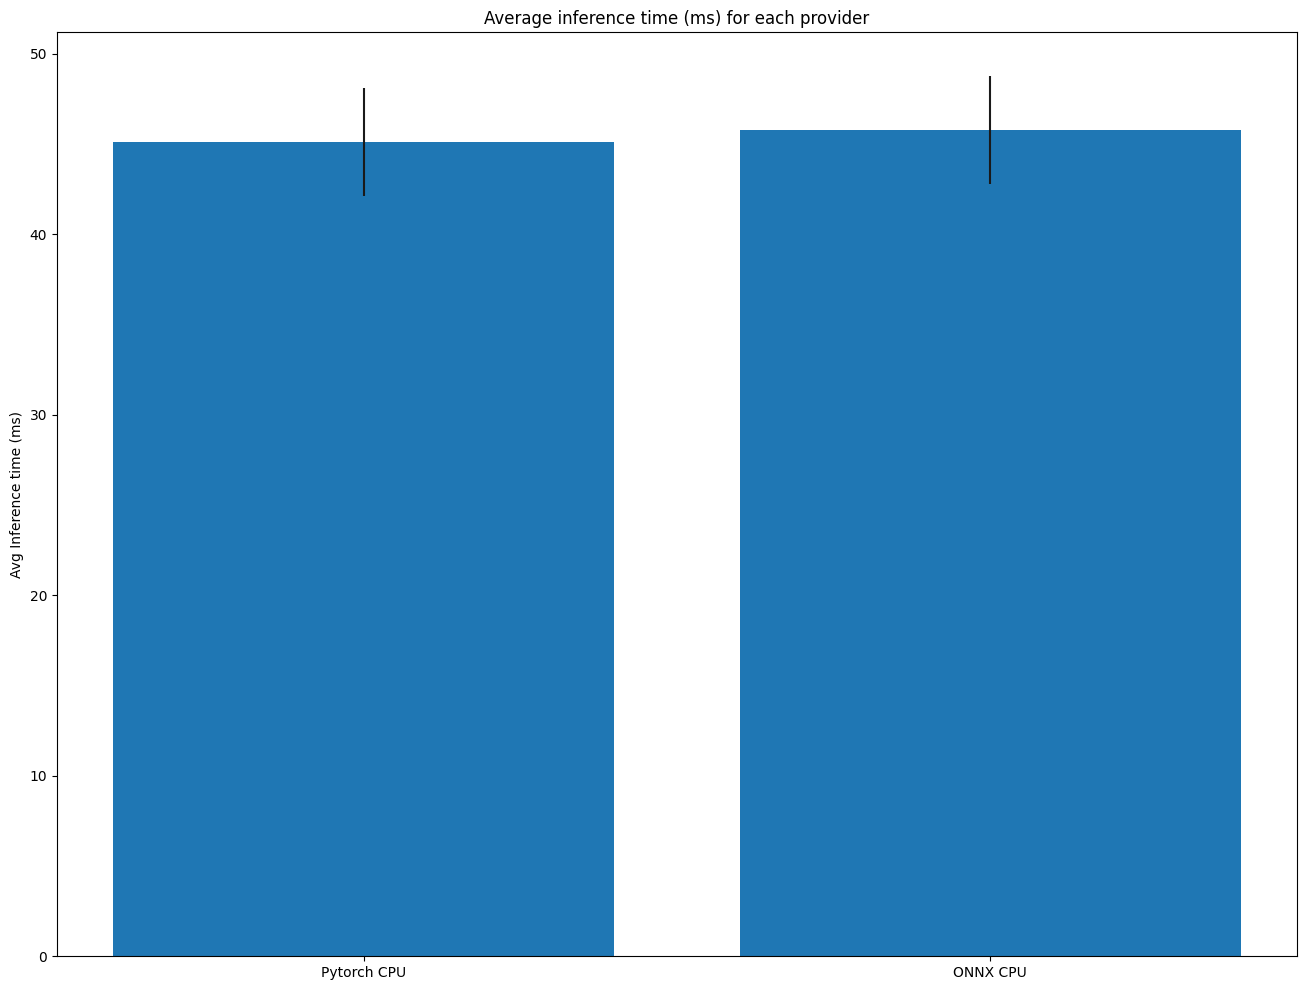

In [12]:
plot_benchmark(results)

In [13]:
# load onnx pipeline
nlp_onnx = pipeline("question-answering",  onnx=True)
# load torch pipeline
nlp_torch = pipeline("question-answering", onnx=False)


Using framework PyTorch: 1.6.0+cu101
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch', 1: 'sequence'}
Found output output_1 with shape: {0: 'batch', 1: 'sequence'}
Ensuring inputs are in correct order
head_mask is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask']


/usr/local/lib/python3.6/dist-packages/transformers/modeling_utils.py:1570: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  input_tensor.shape == tensor_shape for input_tensor in input_tensors


Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch', 1: 'sequence'}
Found output output_1 with shape: {0: 'batch', 1: 'sequence'}


In [14]:
import warnings

Tracking inference time for ONNX CPU: 100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


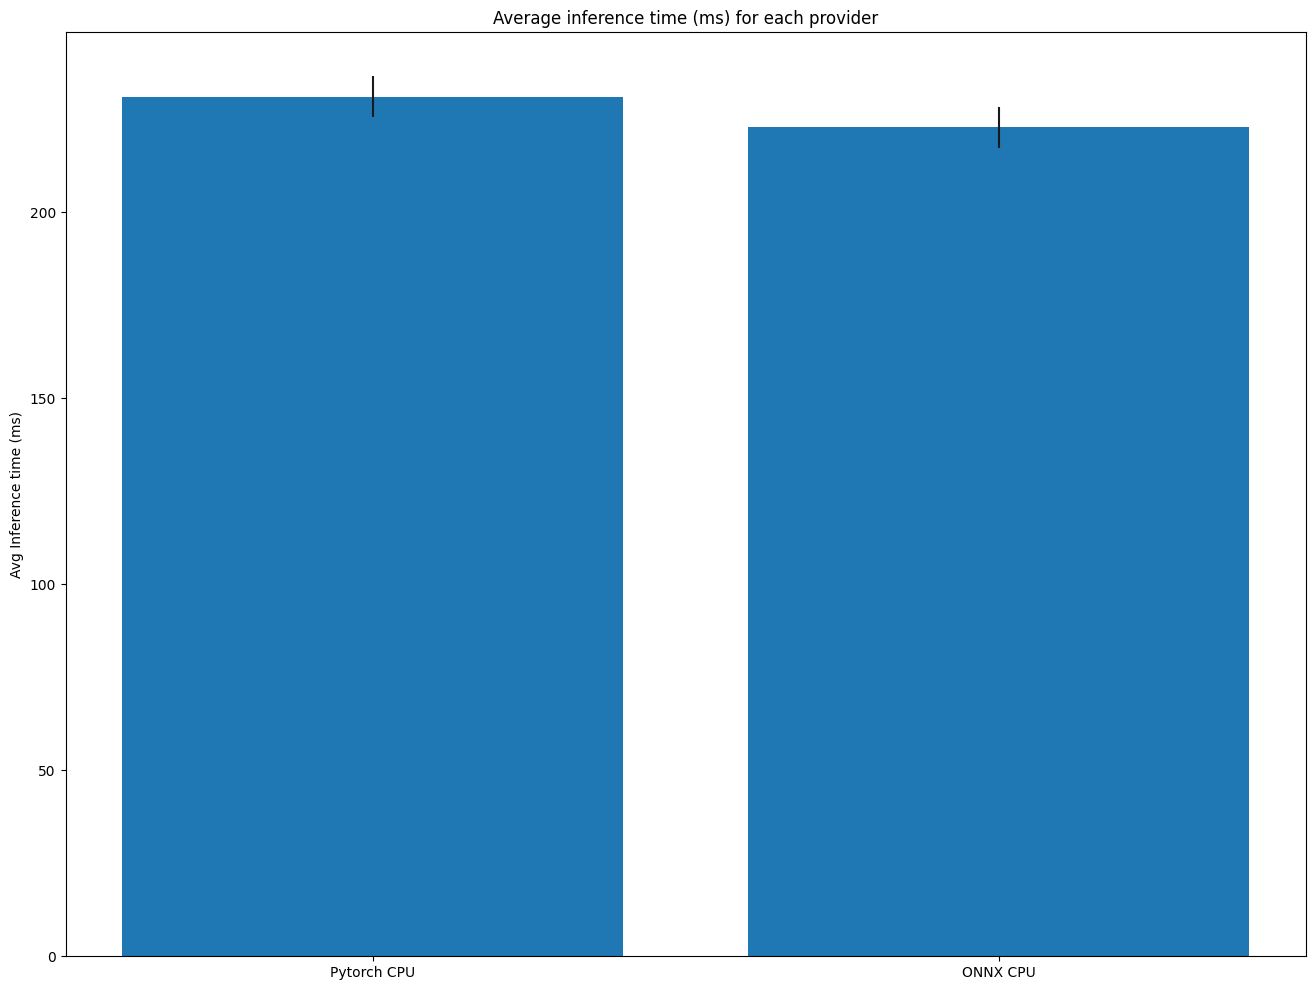

In [15]:
pipelines = [("Pytorch CPU", nlp_torch), ("ONNX CPU", nlp_onnx)]
results = {}
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for label, pipeline_ in pipelines:
      # Compute 
      time_buffer = []
      for _ in trange(100, desc=f"Tracking inference time for {label}"):
        with track_infer_time(time_buffer):
          pipeline_({"question": "What is ONNX runtime ?", "context": "ONNX Runtime is a highly performant single inference engine for multiple platforms and hardware"})

      # Store the result
      results[label] = OnnxInferenceResult(
          time_buffer, 
          None
      )

plot_benchmark(results)